<a href="https://colab.research.google.com/github/Natruja-W/229352-StatisticalLearning/blob/main/Lab02_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# For Fashion-MNIST
from tensorflow.keras.datasets import fashion_mnist

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Part 1: Marketing Campaign Dataset - Manual Data Preprocessing & Logistic Regression

### Load the Marketing Campaign Dataset ([Data Information](https://archive.ics.uci.edu/dataset/222/bank+marketing))

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (`'yes'`) or not (`'no'`) subscribed.

In [ ]:
bank_url = 'https://raw.githubusercontent.com/donlap/ds352-labs/main/bank.csv'

df = pd.read_csv(bank_url, sep=';', na_values=['unknown'])
df = df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx",	"euribor3m", "nr.employed"], axis=1)
print("Shape of the dataset:", df.shape)
df.head()

### Data Exploration

In [ ]:
print("--- Missing Values Count ---")
print(df.isnull().sum())

In [ ]:
print("--- Unique Values for Categorical Columns ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\n'{col}' unique values:")
    print(df[col].value_counts(dropna=False)) # Include NaN counts

### Data Preprocessing

In [ ]:
# Map target variable 'y' to 0 (no) and 1 (yes)
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Drop 'duration' due to data leakage
df = df.drop('duration', axis=1)

# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

# Split the data BEFORE any transformations
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print data shape
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


We will apply `StandardScaler()`, `OrdinalEncoder()`, and `OneHotEncoder()` on a few selected columns.

**1. Numerical Feature: `age` and `campaign` (Standard Scaling)**

In [9]:
num_cols_demo = ['age', 'campaign']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train[num_cols_demo])

# Transform both training and test data
X_train_scaled_demo = scaler.transform(X_train[num_cols_demo])
X_test_scaled_demo = scaler.transform(X_test[num_cols_demo])


Let's take a look at the transformed `age` and `campaign` features and their statistics.

In [ ]:
print("\nOriginal X_train 'age' and 'campaign' head:")
print(X_train[num_cols_demo].head())
print("\nScaled X_train 'age' and 'campaign' head:")
print(pd.DataFrame(X_train_scaled_demo, columns=num_cols_demo, index=X_train.index).head())

print("\nMean of scaled 'age' (train):", X_train_scaled_demo[:, 0].mean())
print("Std Dev of scaled 'campaign' (train):", X_train_scaled_demo[:, 1].std())

**2. Ordinal Feature: `education` (Ordinal Encoding with Imputation)**

- **Imputation**

In [11]:
ord_col_demo = ['education']

imputer_ord = SimpleImputer(strategy='most_frequent')

# Fit only on training data
imputer_ord.fit(X_train[ord_col_demo])

# Transform both training and test data
X_train_imputed_ord_demo = imputer_ord.transform(X_train[ord_col_demo])
X_test_imputed_ord_demo = imputer_ord.transform(X_test[ord_col_demo])


- **Ordinal Encoding**

In [12]:
education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

In [13]:
ordinal_encoder = OrdinalEncoder(categories=[education_categories])

## Write your code here
ordinal_encoder.fit(X_train_imputed_ord_demo)

# Transform both training and test data
X_train_ord_encoded_demo = ordinal_encoder.transform(X_train_imputed_ord_demo)
X_test_ord_encoded_demo = ordinal_encoder.transform(X_test_imputed_ord_demo)

Let's take a look at the imputed and ordinal-encoded `education`.

In [ ]:
print("\nOriginal X_train 'education' head:")
print(X_train[ord_col_demo].iloc[20:25])
print("\nImputed X_train 'education' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_ord_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])
print("\nOrdinal Encoded X_train 'education' head:")
print(pd.DataFrame(X_train_ord_encoded_demo, columns=ord_col_demo, index=X_train.index).iloc[20:25])

**3. Nominal Feature: `job` (One-Hot Encoding with Imputation)**

- **Imputation**

In [16]:
nom_col_demo = ['job']

imputer_nom = SimpleImputer(strategy='most_frequent')
imputer_nom.fit(X_train[nom_col_demo])

X_train_imputed_nom_demo = imputer_nom.transform(X_train[nom_col_demo])
X_test_imputed_nom_demo = imputer_nom.transform(X_test[nom_col_demo])

- **Nominal Encoding**

In [17]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit only on training data (หลังจาก imputation แล้ว)
onehot_encoder.fit(X_train_imputed_nom_demo)

# Transform both training and test sets
X_train_onehot_encoded_demo = onehot_encoder.transform(X_train_imputed_nom_demo)
X_test_onehot_encoded_demo = onehot_encoder.transform(X_test_imputed_nom_demo)


In [ ]:
print("\nOriginal X_train 'job' head:")
print(X_train[nom_col_demo].iloc[40:45])
print("\nImputed X_train 'job' head (after imputer.transform):")
print(pd.DataFrame(X_train_imputed_nom_demo, columns=nom_col_demo, index=X_train.index).iloc[40:45])
print("\nOne-Hot Encoded X_train 'job' shape:", X_train_onehot_encoded_demo.shape)
print("First 5 rows of One-Hot Encoded X_train 'job':")
print(pd.DataFrame(X_train_onehot_encoded_demo, columns=onehot_encoder.get_feature_names_out(nom_col_demo), index=X_train.index).iloc[40:45])

### **Exercise 1: Apply All Preprocessing & Train Logistic Regression**

Now, it's your turn to apply these preprocessing steps to *all* relevant columns and then train a Logistic Regression model.

**Instructions:**

1.  Look at the Variable Table in [this link](https://archive.ics.uci.edu/dataset/222/bank+marketing).
2. Make lists for `numerical_features`, `ordinal_features`, and `nominal_features`.
3. Preprocess the features. It is safer to make a copy of `X_train` using:
   ```
   X_train_copy = X_train.copy()
   X_test_copy = X_test.copy()
   ```
   and preprocess `X_train_copy` instead.

   **For nominal features, concat the one-hot encoded features using [`pd.concat(..., axis=1)`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) and drop the old nominal features from the dataframe.**
4. Train Logistic Regression on the preprocessed `X_train_copy` and `y_train`.
5. Evaluate the Model:
    *   Make predictions on the preprocessed `X_test_copy`.
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?


In [35]:
# --- YOUR CODE FOR EXERCISE 1 STARTS HERE ---
# Make lists for numerical_features, ordinal_features, and nominal_features.
numerical_features = ['age', 'campaign', 'previous', 'pdays']
ordinal_features = ['education']
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Preprocess the features. It is safer to make a copy of X_train
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

scaler = StandardScaler()
X_train_num = pd.DataFrame(
    scaler.fit_transform(X_train_copy[numerical_features]),
    columns=numerical_features,
    index=X_train_copy.index
)
X_test_num = pd.DataFrame(
    scaler.transform(X_test_copy[numerical_features]),
    columns=numerical_features,
    index=X_test_copy.index
)


education_categories = [
    'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
    'professional.course', 'university.degree', 'masters', 'doctorate'
]

# Impute
imputer_ord = SimpleImputer(strategy='most_frequent')
X_train_ord_imp = imputer_ord.fit_transform(X_train_copy[ordinal_features])
X_test_ord_imp = imputer_ord.transform(X_test_copy[ordinal_features])

# Encode
ordinal_encoder = OrdinalEncoder(categories=[education_categories])
X_train_ord = pd.DataFrame(
    ordinal_encoder.fit_transform(X_train_ord_imp),
    columns=ordinal_features,
    index=X_train_copy.index
)
X_test_ord = pd.DataFrame(
    ordinal_encoder.transform(X_test_ord_imp),
    columns=ordinal_features,
    index=X_test_copy.index
)

imputer_nom = SimpleImputer(strategy='most_frequent')
X_train_nom_imp = imputer_nom.fit_transform(X_train_copy[nominal_features])
X_test_nom_imp = imputer_nom.transform(X_test_copy[nominal_features])

# One-hot encode
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_nom = pd.DataFrame(
    onehot_encoder.fit_transform(X_train_nom_imp),
    columns=onehot_encoder.get_feature_names_out(nominal_features),
    index=X_train_copy.index
)
X_test_nom = pd.DataFrame(
    onehot_encoder.transform(X_test_nom_imp),
    columns=onehot_encoder.get_feature_names_out(nominal_features),
    index=X_test_copy.index
)

imputer_nom = SimpleImputer(strategy='most_frequent')
X_train_nom_imp = imputer_nom.fit_transform(X_train_copy[nominal_features])
X_test_nom_imp = imputer_nom.transform(X_test_copy[nominal_features])

# One-hot encode
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_nom = pd.DataFrame(
    onehot_encoder.fit_transform(X_train_nom_imp),
    columns=onehot_encoder.get_feature_names_out(nominal_features),
    index=X_train_copy.index
)
X_test_nom = pd.DataFrame(
    onehot_encoder.transform(X_test_nom_imp),
    columns=onehot_encoder.get_feature_names_out(nominal_features),
    index=X_test_copy.index
)

X_train_final = pd.concat([X_train_num, X_train_ord, X_train_nom], axis=1)
X_test_final = pd.concat([X_test_num, X_test_ord, X_test_nom], axis=1)


#Train Logistic Regression on the preprocessed X_train_copy and y_train
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_final, y_train)

#Evaluate the Model
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_final)

report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.70      0.18      0.29       928

    accuracy                           0.90      8238
   macro avg       0.80      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



## Part 2: Fashion-MNIST Dataset - Image Classification

### Load Fashion-MNIST Dataset

The Fashion-MNIST dataset consists of 28x28 grayscale images of fashion items.

In [ ]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

print(f"Fashion-MNIST Train data shape: {fm_X_train.shape}")
print(f"Fashion-MNIST Train labels shape: {fm_y_train.shape}")
print(f"Fashion-MNIST Test data shape: {fm_X_test.shape}")
print(f"Fashion-MNIST Test labels shape: {fm_y_test.shape}")

In [ ]:
print(f"First image {fm_X_train[0]}")
print(f"First label {fm_y_train[0]}")

### Visualize Fashion-MNIST Images

Let's see what these images look like.

In [ ]:
fashion_mnist_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Visualize the images
## Write your code here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))


for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(fm_X_train[i], cmap='gray')
    plt.title(fashion_mnist_class_names[fm_y_train[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()



### **Exercise 2: Preprocessing Images (Flatten and Scale)**

Images are 2D arrays (matrices of pixels) and pixel values are integers from 0-255. For Logistic Regression, we need:
*  **Flattening:** Convert each 28x28 image into a 1D array of 784 features.
*  **Scaling:** Normalize pixel values from [0, 255] to [0, 1].

**Instructions:**

1.   **Flatten:** Use the `.reshape()` method (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html)). For `fm_X_train_binary` (shape `(num_samples, 28, 28)`), you want to reshape it to `(num_samples, 28*28)`.
2.  **Scale:** Divide the flattened pixel values by 255.0 to get values between 0 and 1.
3.   **Train Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
    *   Fit the model on your *processed* `fm_X_train_scaled` and `fm_y_train`.
4.   **Make Predictions:** Use `predict()` to make predictions on the *processed* `fm_X_test_scaled`.
5.   **Print Classification Report:** Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?
6.   **Visualize Misclassifications:**
    *   Find the indices in `fm_X_test_binary` where your model made incorrect predictions (i.e., `fm_y_pred != fm_y_test`).
    *   Select 5 of these misclassified images.
    *   Plot these images (using `plt.imshow`). For each image, print its true label and its predicted label.

(60000, 784)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.86      0.85      1000
           4       0.74      0.76      0.75      1000
           5       0.95      0.92      0.94      1000
           6       0.63      0.57      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.94      0.93      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



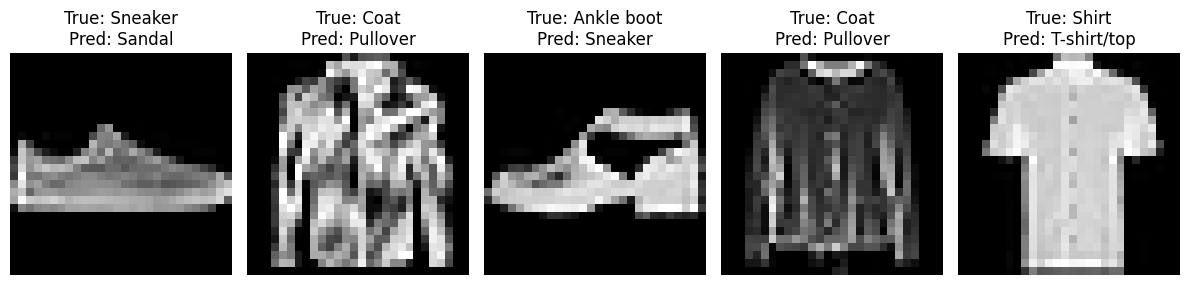

In [34]:
# --- YOUR CODE FOR EXERCISE 2 STARTS HERE ---
# Flatten
fm_X_train_flat = fm_X_train.reshape(fm_X_train.shape[0], -1)
fm_X_test_flat = fm_X_test.reshape(fm_X_test.shape[0], -1)

print(fm_X_train_flat.shape)

#Scale

fm_X_train_scaled = fm_X_train_flat / 255.0
fm_X_test_scaled = fm_X_test_flat / 255.0

#Train Logistic Regression
model = LogisticRegression(solver='saga', max_iter=100, random_state=42, n_jobs=-1)
model.fit(fm_X_train_scaled, fm_y_train)

# Predict
fm_y_pred = model.predict(fm_X_test_scaled)

# Evaluate the model
print(classification_report(fm_y_test, fm_y_pred))


#Visualize Misclassifications
misclassified_idxs = np.where(fm_y_pred != fm_y_test)[0]
sample_idxs = misclassified_idxs[:5]

plt.figure(figsize=(12, 6))

for i, idx in enumerate(sample_idxs):
    plt.subplot(1, 5, i + 1)
    plt.imshow(fm_X_test[idx], cmap='gray')
    true_label = fashion_mnist_class_names[fm_y_test[idx]]
    pred_label = fashion_mnist_class_names[fm_y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()



## Part 3: 20 Newsgroups Dataset - Text Classification

### Load 20 Newsgroups Dataset

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics.

In [ ]:
news_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
news_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42)

X_train_news, y_train_news = news_train.data, news_train.target
X_test_news, y_test_news = news_test.data, news_test.target

print(f"Number of training documents: {len(X_train_news)}")
print(f"Number of test documents: {len(X_test_news)}")
print(f"Categories: {news_train.target_names}")

### Explore Sample Document

In [ ]:
# Print the first document and its class
## Write your code here
print(X_train_news[0])
print(news_train.target_names[y_train_news[0]])



### Preprocessing: Text Vectorization Demonstration with `TfidfVectorizer`

$$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$$

Where:

$$
\text{TF}(t, d) = \frac{\text{number of word }t\text{ in } d}{\text{number of words in } d} \quad \text{ and } \quad
\text{IDF}(t, D) = \log\left(\frac{\text{total number of documents}}{\text{number of documents that contain word }t}\right).
$$

In [ ]:
sample_sentences = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?"
]

vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the sample sentences
sample_vec_output_sparse = vectorizer.fit_transform(sample_sentences)

sample_vec_output_dense = sample_vec_output_sparse.toarray()

print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())
print(sample_vec_output_dense)

### **Exercise 3: Apply TF-IDF Vectorization to Full Dataset**

Now, apply `TfidfVectorizer` to the actual training and testing datasets for the 20 Newsgroups classification task.

**Instructions:**

1.  **Initialize `TfidfVectorizer`:**
    *   Initialize `TfidfVectorizer`. Use `stop_words='english'` to remove common words.
2.  **Fit and Transform Training Data:**
    *   Call `fit_transform()` on `X_train_news` to learn the vocabulary and transform the training text into TF-IDF features. Store the result in `X_train_vec`.
3.  **Transform Test Data:**
    *   Call `transform()` on `X_test_news` using the *already fitted* vectorizer. Store the result in `X_test_vec`. **Crucially, do not call `fit_transform()` on the test data!** This would cause data leakage.
4.  **Initialize Logistic Regression:**
    *   Initialize `LogisticRegression(solver='saga')`. `saga` is a good solver when both number of samples and number of features are large.
5.  **Train the Model:**
    *   Fit the model on your `X_train_vec` and `y_train_news`.
6.  **Make Predictions:**
    *   Make predictions using `predict()` on the `X_test_vec`.
7.  **Evaluate the Model:**
    *   Print `classification_report` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). What are the accuracy, average precision, average recall, and average f1-score?

In [32]:
# --- YOUR CODE FOR EXERCISE 3 STARTS HERE ---
#Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

#Fit and Transform Training Data
X_train_vec = vectorizer.fit_transform(X_train_news)

# Transform Test Data
X_test_vec = vectorizer.transform(X_test_news)

#Initialize Logistic Regression
model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)

#Train the Model
model.fit(X_train_vec, y_train_news)

# Make Predictions
y_pred = model.predict(X_test_vec)

#Evaluate the model
print(classification_report(y_test_news, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.73      0.76       319
           1       0.71      0.80      0.75       389
           2       0.75      0.76      0.75       394
           3       0.71      0.74      0.72       392
           4       0.80      0.83      0.82       385
           5       0.85      0.75      0.79       395
           6       0.78      0.87      0.82       390
           7       0.90      0.89      0.90       396
           8       0.94      0.95      0.94       398
           9       0.88      0.92      0.90       397
          10       0.94      0.96      0.95       399
          11       0.95      0.91      0.93       396
          12       0.75      0.78      0.76       393
          13       0.88      0.86      0.87       396
          14       0.89      0.91      0.90       394
          15       0.81      0.93      0.87       398
          16       0.75      0.90      0.82       364
          17       0.97    